In [40]:
import numpy as np
from numpy import linalg
import sklearn 
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_svmlight_file
import math
import pandas as pd
from datetime import datetime
from scipy.spatial import distance
import re
import matplotlib.pyplot as plt
import scipy.stats as sts
from scipy.stats import ortho_group
m = ortho_group.rvs(dim=3)
from sklearn import ensemble, model_selection, metrics, tree
%matplotlib inline
from sklearn.datasets import load_digits
import time
import pylab

In [3]:
dataset = "a9a.txt"
data = load_svmlight_file(dataset)
X1, y1 = data[0].toarray(), data[1]
n1, d1 = X1.shape

X2, y2 = data[0].toarray(), data[1]
n2, d2 = X2.shape

X3, y3 = data[0].toarray(), data[1]
n3, d3 = X3.shape

In [4]:
X = np.vstack([X1, X2, X3])
y = np.concatenate([y1, y2, y3])
N, d = X.shape
print(N, d)

97683 123


In [5]:
mu=0.0
std = 0.05 * np.std(X) # for %5 Gaussian noise
def gaussian_noise(x,mu,std):
    noise = np.random.normal(mu, std, size = x.shape)
    x_noisy = x + noise
    return x_noisy 
X = gaussian_noise(X, mu, std)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)
N_train, d_train = X_train.shape
N_test, d_test = X_test.shape

In [9]:
lamb = 0.01

#### Рассматриваем задачу Ridge Regression
$\underset{\omega}{min}[ \frac{1}{2N} ||X\omega - y||^2 + \frac{\lambda}{2}||\omega||^2]$, $q(\omega) = \frac{1}{2N} ||X\omega - y||^2, p(\omega) = \frac{\lambda}{2}||\omega||^2$

Найдем в явном виде $\arg\underset{x}{min} [p(\omega_k^g) + <\nabla p(\omega_k^g), \nabla p(\omega_k^g)> + \frac{1}{2\Theta}||x - \omega_k^g||^2 + q(x)]$.

Возьмем градиент и приравняем его к нулю: $\nabla p(\omega_k^g) + \frac{1}{\Theta}(x - \omega_k^g) + \nabla q(x) = 0$

$\lambda\omega_k^g + \frac{1}{\Theta}(Ix - \omega_k^g) + \frac{1}{N}X^T(Xx - y) = 0$

$x = (I\frac{1}{\Theta} + \frac{1}{N}X^TX)^{-1}(\frac{1}{\Theta} \omega_k^g + \frac{1}{N}X^Ty - \lambda\omega_k^g)$
Тогда в агоритме 1 в строчке 5: $x_f^{k+1} = x$

In [10]:
L = max(np.linalg.eigvals(1/N_train*X_train.T.dot(X_train) + np.identity(d)*lamb))
mu = min(np.linalg.eigvals(1/N_train*X_train.T.dot(X_train) + np.identity(d)*lamb))
L_q = max(np.linalg.eigvals(1/N_train*X_train.T.dot(X_train)))
mu_q = min(np.linalg.eigvals(1/N_train*X_train.T.dot(X_train)))
L_p = max(np.linalg.eigvals(np.identity(d)*lamb))
mu_p = min(np.linalg.eigvals(np.identity(d)*lamb))
print("L =", L)
print("mu =", mu)
print("$L_q$ =", L_q)
print("$mu_q$ =", mu_q)
print("$L_p$ =", L_p)
print("$mu_p$ =", mu_p)

L = 6.296980949275191
mu = 0.01024263255112241
$L_q$ = 6.286980949275195
$mu_q$ = 0.00024263255112234327
$L_p$ = 0.01
$mu_p$ = 0.01


In [9]:
omega_true = np.linalg.inv(1/N_train*X_train.T@X_train + np.eye(d)*0.01)@(1/N_train*X_train.T@y_train)
print(gradient_r(X_train, y_train, omega_true, 0.01).dot(gradient_r(X_train, y_train, omega_true, 0.01)))

NameError: name 'gradient_r' is not defined

In [160]:
number_of_true_precisions = 0
for i in range (N_test): 
    if (omega_true.dot(X_test[i]) >= 0):
        k = 1
    else:
        k = -1
    if (k == y_test[i]):
        number_of_true_precisions = number_of_true_precisions + 1   
procent_of_precisions = number_of_true_precisions/y_test.shape[0]
print(procent_of_precisions)

0.8431181860060398


### Algorithm 1

In [11]:
omega_true = np.linalg.inv(1/N_train*X_train.T.dot(X_train) + np.eye(d)*0.01).dot(1/N_train*X_train.T.dot(y_train))
def gradient_r(X, y, omega, lamb):
    return 1/N_train*X.T.dot(X.dot(omega) - y) + lamb*omega
def gradient_q(X, y, omega):
    return 1/N_train*X.T.dot(X.dot(omega) - y)
def gradient_p(omega, lamb):
    return lamb*omega

def accelarated_extragradient(tau, eta, theta, alpha, lamb, X, y, start, amount_of_iterations):
    omega = start
    omega = omega.reshape(1, d)
    omega_f = start
    omega_f = omega_f.reshape(1, d)
    begin_time = time.time()
    timeprog = []

    for i in range (amount_of_iterations):

        
        omega_gk = tau*omega[i-1] + (1 - tau)*omega_f[i-1]
        omega_f_next = np.linalg.inv(np.identity(d)/theta + 1/N_train*X.T.dot(X)).dot(1/theta*omega_gk + 1/N_train*X.T.dot(y) - lamb*omega_gk)
        
        grad_r = gradient_r(X, y, omega_f_next, lamb)

        omega = np.vstack([omega, omega[i-1] + eta*alpha*(omega_f_next - omega[i-1]) - eta*grad_r])
        omega_f = np.vstack([omega_f, omega_f_next])
        
        timeprog.append(time.time() - begin_time)
    return omega, timeprog

In [162]:
res1, time1 = accelarated_extragradient(0.75, 1/L, 0.01, 0.01, 0.01, X_train, y_train, np.ones(d), 10000)

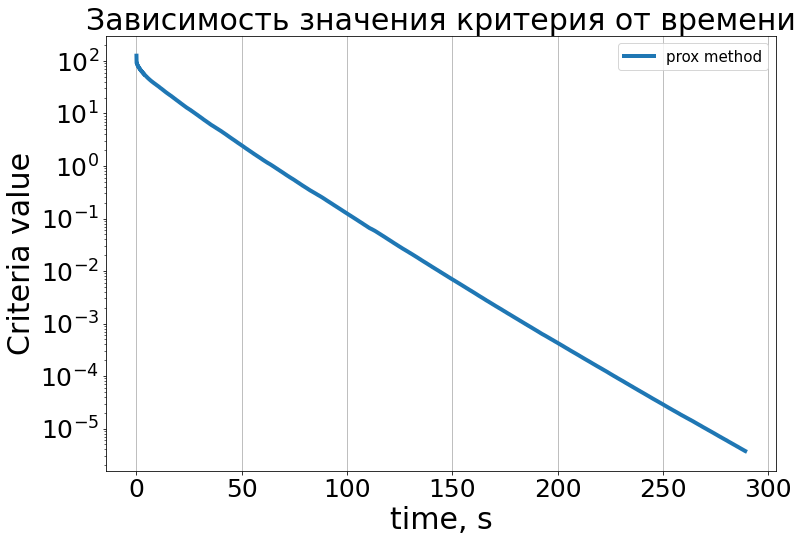

In [175]:
X1 = np.array([])
for i in range (0, 9998):
    X1 = np.append(X1, time1[i])
Y1 = np.array([])
for i in range (0, 9998):
    Y1 = np.append(Y1, (res1[i] - omega_true)@(res1[i] - omega_true))
    
plt.figure(figsize=(12, 8))

plt.semilogy(X1, Y1, linewidth=4, label = 'prox method')

plt.legend(loc="upper right", fontsize=15)
plt.xlabel(r"time, s", fontsize=30)
plt.ylabel("Criteria value", fontsize=30)
plt.title(r"Зависимость значения критерия от времени", fontsize=30)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)


plt.grid(axis = 'x')

### Найдем время работы при случайном распределении датасета

In [293]:
def find_max_time(X, y, omega, omega_f, b, tau, eta, theta, alpha, lamb, t_loc):
    timeprog = []
    for i in range (b.shape[0]):
        a = np.arange(0, int(b[i]), 1)
        X_new = X[a]
        y_new = y[a]
        
        begin_time = time.time()
        omega_gk = tau*omega + (1 - tau)*omega_f[i-1]
        omega_f_next = np.linalg.inv(np.identity(d)/theta + 1/N*X_new.T.dot(X_new))@(1/theta*omega_gk.T + 1/N*X_new.T.dot(y_new) - lamb*omega_gk.T)      
        gradient_r(X_new, y_new, omega_f_next, lamb)
        timeprog.append((time.time() - begin_time)*t_loc[i])
    return np.argmax(timeprog)


def accelarated_extragradient_division(tau, eta, theta, alpha, lamb, X, y, start, amount_of_iterations, b, t_loc, t_comm):
    omega = start
    omega = omega.reshape(1, d)
    omega_f = start
    omega_f = omega_f.reshape(1, d)
    k = find_max_time(X, y, start, start, b, tau, eta, theta, alpha, lamb, t_loc)
    if k == 0:
        multiply = 1
    else:
        multiply = 5
    timeprog = []
    for i in range (amount_of_iterations):
        a = np.arange(0, int(b[k]), 1)
        X_max = X[a]
        y_max = y[a]
        begin_time = time.time()
        omega_gk = tau*omega[i-1] + (1 - tau)*omega_f[i-1]
        omega_f_next = np.linalg.inv(np.identity(d)/theta + 1/N*X_max.T.dot(X_max)).dot(1/theta*omega_gk + 1/N*X_max.T.dot(y_max) - lamb*omega_gk)
        
        grad_r = gradient_r(X, y, omega_f_next, lamb)

        omega = np.vstack([omega, omega[i-1] + eta*alpha*(omega_f_next - omega[i-1]) - eta*grad_r])
        omega_f = np.vstack([omega_f, omega_f_next])
    
        timeprog.append(multiply*(time.time() - begin_time) + t_comm)
    return omega, timeprog

In [75]:
def generate_t_loc():
    t_loc = [5 for x in range(21)]
    t_loc[0] = 1
    t_loc = np.array(t_loc)
    return t_loc
t_loc = generate_t_loc()

def generate_b(t_loc):
    b = np.random.randint(1, N, t_loc.shape[0] - 1)
    b = np.sort(b)
    b = np.append(b, N)
    b1 = np.array([])
    for i in range (t_loc.shape[0] - 1):
        b1 = np.append(b1, b[i+1] - b[i])        
    return b1
b = generate_b(t_loc)
print(b)

[ 1494. 18400.  1539.  2762.  2520.  8668.  2644.  1415.  6090.  6519.
 12309.  2439.  3910.  2982.  8419.  1323.  1643.  1677.  1074.  3284.]


In [294]:
res2, time2 = accelarated_extragradient_division(0.75, 1/L, 0.01, 0.01, 0.01, X, y, np.ones(d), 10000, b, t_loc, 0.0075/5 *(N**(1.67)))

In [295]:
print(sum(time2))

3229156248.06114


### Найдем время работы в случае больших коммуникаций

In [13]:
epsilon = 4.855708467588126e-09
c1 = 700.0602944751523
c2 = c1*1000
alpha = c1*(L/mu)**0.5*np.log(1/epsilon)
beta = c2*(L/mu)**0.5*np.log(1/epsilon)

def generate_t_loc1():
    t_loc1 = [5 for x in range(21)]
    t_loc1[0] = 1
    t_loc1 = np.array(t_loc1)
    return t_loc1
t_loc1 = generate_t_loc1()

def generate_b1(t_loc1, comm):
    b1 = np.array([])
    b1 = np.append(b1, min(N, round((comm*c1/(4*c2))**0.8)))
    last = N
    for i in range (1, t_loc1.shape[0]):
        last = last - b1[-1]
        b1 = np.append(b1, round(last/(t_loc1.shape[0] - i)))
    return b1
b1 = generate_b1(t_loc1, N**(1.7))
print(b1)

[8026. 4483. 4483. 4483. 4483. 4483. 4483. 4483. 4483. 4483. 4483. 4483.
 4483. 4483. 4483. 4482. 4483. 4482. 4483. 4482. 4483.]


In [288]:
res3, time3 = accelarated_extragradient_division(0.75, 1/L, 0.01, 0.01, 0.01, X, y, np.ones(d), 10000, b1, t_loc1, 0.0075/5 *(N**(1.67)))

In [322]:
print(sum(time3),sum(time2))

3229156185.501327 3229156248.06114


### Найдем время работы в случае малых коммуникаций

In [14]:
def generate_t_loc2():
    t_loc1 = np.random.randint(3, 7, 21)
    t_loc1[0] = 1
    t_loc1 = np.array(t_loc1)
    return t_loc1
t_loc2 = generate_t_loc2()

def generate_b2(t_loc2):
    b1 = np.array([])
    S = (sum(1/t_loc2[i] for i in range(1, t_loc2.shape[0])))**(-1)
    b1 = np.append(b1, round(N*S/(t_loc2[0] + S)))
    last = N 
    for i in range (1, t_loc2.shape[0]):
        last -= b1[-1]
        S = (sum(1/t_loc2[k] for k in range(i, t_loc2.shape[0])))**(-1)
        b1 = np.append(b1, round(last/t_loc2[i]*S))
    return b1
b2 = generate_b2(t_loc1)
print(b2)

[19537.  3907.  3907.  3907.  3907.  3907.  3907.  3907.  3907.  3908.
  3907.  3908.  3907.  3908.  3907.  3908.  3907.  3908.  3907.  3908.
  3907.]


In [300]:
res4, time4 = accelarated_extragradient_division(0.75, 1/L, 0.01, 0.01, 0.01, X, y, np.ones(d), 10000, b2, t_loc2, 1e-9)

In [301]:
res5, time5 = accelarated_extragradient_division(0.75, 1/L, 0.01, 0.01, 0.01, X, y, np.ones(d), 10000, b, t_loc, 1e-9)

In [303]:
print(sum(time4), sum(time5))

623.3800952297964 639.5168249470508


Видим, что есть ускорение, но оно крайне малое относительно времени работы. В чем же дело? Дело в том, что питон перемножает матрицы за крайне малое время и таким образом реальное $k_{some}$ и $max(t_1, ..., t_n)$ слишком малы по сравнению с коммуникациями в первом случае, а во втором случае просто малы, чтобы давать значительный эффект на оптимально распределенном датасете. Покажем это

In [328]:
finalXX = []
for i in range (100):
    begin_time = time.time()
    np.linalg.inv(X.T.dot(X))
    finalXX.append(time.time() - begin_time)
XX = sum(finalXX)/100
finalXy = []
for i in range (100):
    begin_time = time.time()
    X.T.dot(y)
    finalXy.append(time.time() - begin_time)
Xy = sum(finalXy)/100
final = []
for i in range (100):
    begin_time = time.time()
    X.T.dot(X.dot(np.ones(d)) - y)
    final.append(time.time() - begin_time)
gr = sum(final)/100
tim = (XX + Xy)/gr
print(r"Полный градиент q быстрее чем матрица * матрица + столбец * столбец в ", tim, "раз")
print(r"матрица * матрица", XX, r"стоблец * столбец", Xy, "Полный градиент q", gr)

Полный градиент q быстрее чем матрица * матрица + столбец * столбец в  3.202085727592249 раз
матрица * матрица 0.019334537982940672 стоблец * столбец 0.003450765609741211 Полный градиент q 0.007115769386291504


### Для решения этой проблемы строчку 5 в имплементируемом алгоритме будем находить не аналитически, а итеративным спуском $(OGM-G)$

In [15]:
def gradient(X, y, omega):
    return 1/N*X.T.dot(X.dot(omega) - y)

In [16]:
def OGM_G(X, y, start,L,iterations):
    thetas=np.zeros(iterations+1)
    #Разбираемся с последователньостью Тетт
    thetas[0]=1
    for i in range(1,iterations):
        thetas[i]=(1+math.sqrt(1+4*thetas[i-1]**2))/2  
    thetas[-1]=(1+math.sqrt(1+8*thetas[i-1]**2))/2
    
    thetas=np.flip(thetas)
    
    x=start
    y1=start
    gradients=[]
    timeprog = []
    begin_time = time.time()
    for i in range(1,iterations-1):
        y_old = y1
        y1 = x - gradient(X, y, x)/L
        x=y1+(thetas[i]-1)*(2*thetas[i+1]-1)*(y1-y_old)/thetas[i]/(2*thetas[i]-1)+(2*thetas[i+1]-1)*(y1-x)/(2*thetas[i]-1)
        gradients.append(np.linalg.norm(gradient(X, y, x))**2)
        timeprog.append(time.time() - begin_time)
    return x,gradients, timeprog

In [107]:
OGM_G_RESULTS=OGM_G(X, y, np.ones(d),L,2000)

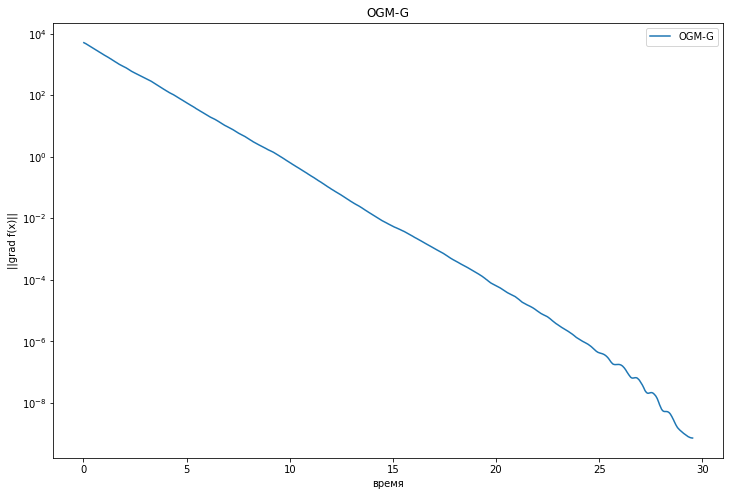

In [108]:
plt.figure(figsize=(12, 8))
plt.plot(OGM_G_RESULTS[2],OGM_G_RESULTS[1],label='OGM-G')

plt.yscale('log')
plt.legend()
plt.xlabel('время')
plt.ylabel('||grad f(x)||')
plt.title("OGM-G")
plt.show()

#### Тогда получим новый алгоритм 

In [111]:
def find_max_time(X, y, omega, omega_f, b, tau, eta, theta, alpha, lamb, t_loc, t_comm):
    timeprog = []
    for i in range (b.shape[0]):
        if b[i] != 0 :
            a = np.arange(0, int(b[i]), 1)
            X_new = X[a]
            y_new = y[a]
            if i == 0:
                is_local = 0
            else:
                is_local = 1

            begin_time = time.time()
            omega_gk = tau*omega + (1 - tau)*omega_f[i-1]
            omega_f_next = OGM_G(X_new, y_new, np.ones(d), L, 2000)  
            gradient_r(X_new, y_new, omega_f_next[0], lamb)
            timeprog.append((time.time() - begin_time)*t_loc[i] + t_comm*is_local)
        else:
            timeprog.append(0)
    return np.argmax(timeprog)


def accelarated_extragradient_division(tau, eta, theta, alpha, lamb, X, y, start, amount_of_iterations, b, t_loc, t_comm):
    omega = start
    omega = omega.reshape(1, d)
    omega_f = start
    omega_f = omega_f.reshape(1, d)
    k = find_max_time(X, y, start, start, b, tau, eta, theta, alpha, lamb, t_loc, t_comm)
    multiply = t_loc[k]
    timeprog = []
    if k == 0:
        is_local = 0
    else:
        is_local = 1
    print("k = ", k)
    for i in range (amount_of_iterations):
        a = np.arange(0, int(b[k]), 1)
        X_max = X[a]
        y_max = y[a]
        begin_time = time.time()
        omega_gk = tau*omega[i-1] + (1 - tau)*omega_f[i-1]
        omega_f_next = OGM_G(X_max, y_max, np.ones(d), L, 2000)
        
        grad_r = gradient_r(X, y, omega_f_next[0], lamb)

        omega = np.vstack([omega, omega[i-1] + eta*alpha*(omega_f_next[0] - omega[i-1]) - eta*grad_r])
        omega_f = np.vstack([omega_f, omega_f_next[0]])
    
        timeprog.append(multiply*(time.time() - begin_time) + t_comm*is_local)
    return omega, timeprog

### Для больших коммуникаций

In [431]:
res1, time1 = accelarated_extragradient_division(0.75, 1/L, 0.01, 0.01, 0.01, X, y, np.ones(d), 100, b, t_loc2, 53)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [432]:
res2, time2 = accelarated_extragradient_division(0.75, 1/L, 0.01, 0.01, 0.01, X, y, np.ones(d), 100, b1, t_loc1, 53)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [467]:
print("ускорили выполнение программы в {:.1f} раза".format(sum(time1)/sum(time2)))

ускорили выполнение программы в 1.4 раза


In [229]:
acceleration_big = []
for i in range (-5, 4):
    b1 = generate_b1(t_loc, 10**(i + 9))
    res1, time1 = accelarated_extragradient_division(0.75, 1/L, 0.01, 0.01, 0.01, X, y, np.ones(d), 5, b, t_loc, 0.9*53*(10**i))
    res2, time2 = accelarated_extragradient_division(0.75, 1/L, 0.01, 0.01, 0.01, X, y, np.ones(d), 5, b1, t_loc, 0.9*53*(10**i))
    acceleration_big.append(sum(time1)/sum(time2))
    print(i)

k =  1
k =  9
-5
k =  1
k =  20
-4
k =  1
k =  2
-3
k =  1
k =  16
-2
k =  1
k =  7
-1
k =  1
k =  20
0
k =  1
k =  0
1
k =  1
k =  0
2
k =  1
k =  0
3


In [110]:
print(generate_b1(t_loc, 10**10))

[97683.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.]


### Для малых коммуникаций

In [67]:
res3, time3 = accelarated_extragradient_division(0.75, 1/L, 0.01, 0.01, 0.01, X, y, np.ones(d), 50, b, t_loc2, 1e-9)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [68]:
res4, time4 = accelarated_extragradient_division(0.75, 1/L, 0.01, 0.01, 0.01, X, y, np.ones(d), 50, b2, t_loc2, 53)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [69]:
print("ускорили выполнение программы в {:.1f} раза".format(sum(time3)/sum(time4)))

ускорили выполнение программы в 1.3 раза


In [230]:
acceleration_small = []
for i in range (-15, -4):
    res1, time1 = accelarated_extragradient_division(0.75, 1/L, 0.01, 0.01, 0.01, X, y, np.ones(d), 5, b, t_loc, 0.9*53*(10**i))
    res2, time2 = accelarated_extragradient_division(0.75, 1/L, 0.01, 0.01, 0.01, X, y, np.ones(d), 5, b2, t_loc, 0.9*53*(10**i))
    acceleration_small.append(sum(time1)/sum(time2))
    print(i)

k =  1
k =  0
-15
k =  1
k =  0
-14
k =  1
k =  0
-13
k =  1
k =  0
-12
k =  1
k =  0
-11
k =  1
k =  0
-10
k =  1
k =  0
-9
k =  1
k =  0
-8
k =  1
k =  0
-7
k =  1
k =  0
-6
k =  1
k =  0
-5


## Общая оптимизация

In [236]:
from scipy.optimize import minimize_scalar
from math import ceil, floor

def minimum_finding(t_comm):
    sum_t_loc = 1/(sum(1/t_loc2[i] for i in range(1, t_loc2.shape[0])))
    b_1_0 = N*(sum_t_loc)/(sum_t_loc + t_loc2[0])
    #0 < b_1 <= b_1_0

    a1 = - alpha * sum_t_loc
    b1 = alpha * (sum_t_loc * N + t_comm)
    c1 = beta * t_loc2[0]

    a2 = alpha * t_loc2[0]
    b2 = alpha * (t_comm)
    c2 = beta * t_loc2[0]
    
    def func1(x):
        return a1*x**(3/4) + b1*x**(-1/4) + c1*x
    def func2(x):
        return a2*x**(3/4) + b2*x**(-1/4) + c2*x

    res1 = minimize_scalar(func1, bounds=(1,floor(b_1_0)), method='bounded')
    res2 = minimize_scalar(func2, bounds=(ceil(b_1_0),N), method='bounded')

    #print(b_1_0)
    
    res11 = floor(res1.x)
    res12 = ceil(res1.x)
    res21 = floor(res2.x)
    res22 = ceil(res2.x)
    fres11 = func1(res11)
    fres12 = func1(res12)
    fres21 = func2(res21)
    fres22 = func2(res22)

    if (fres11 < fres12):
        result1 = [res11, fres11]
    else:
        result1 = [res12, fres12]


    if (fres21 < fres22):
        result2 = [res21, fres21]
    else:
        result2 = [res22, fres22]
    
    if (result1[1] < result2[1]):
        result = [result1[0], result1[1]]
    else:
        result = [result2[0], result2[1]]

    return result[0]

In [118]:
def generate_b_opt(t_loc2, comm):
    b1 = np.array([])
    b1 = np.append(b1, minimum_finding(comm))
    last = N 
    for i in range (1, t_loc2.shape[0]):
        last -= b1[-1]
        S = (sum(1/t_loc2[k] for k in range(i, t_loc2.shape[0])))**(-1)
        b1 = np.append(b1, round(last/t_loc2[i]*S))
    return b1

In [231]:
acceleration_opt = []
for i in range (-15, 4):
    print(i)
    b_opt = generate_b_opt(t_loc, 10**(i + 9))
    print(b_opt)
    res1, time1 = accelarated_extragradient_division(0.75, 1/L, 0.01, 0.01, 0.01, X, y, np.ones(d), 5, b, t_loc, 0.9*53*(10**i))
    res2, time2 = accelarated_extragradient_division(0.75, 1/L, 0.01, 0.01, 0.01, X, y, np.ones(d), 5, b_opt, t_loc, 0.9*53*(10**i))
    acceleration_opt.append(sum(time1)/sum(time2))
    

-15
[4.000e+00 4.884e+03 4.884e+03 4.884e+03 4.884e+03 4.884e+03 4.884e+03
 4.884e+03 4.884e+03 4.884e+03 4.884e+03 4.884e+03 4.884e+03 4.884e+03
 4.884e+03 4.884e+03 4.884e+03 4.884e+03 4.884e+03 4.884e+03 4.883e+03]
k =  1
k =  20
-14
[4.000e+00 4.884e+03 4.884e+03 4.884e+03 4.884e+03 4.884e+03 4.884e+03
 4.884e+03 4.884e+03 4.884e+03 4.884e+03 4.884e+03 4.884e+03 4.884e+03
 4.884e+03 4.884e+03 4.884e+03 4.884e+03 4.884e+03 4.884e+03 4.883e+03]
k =  1
k =  5
-13
[4.000e+00 4.884e+03 4.884e+03 4.884e+03 4.884e+03 4.884e+03 4.884e+03
 4.884e+03 4.884e+03 4.884e+03 4.884e+03 4.884e+03 4.884e+03 4.884e+03
 4.884e+03 4.884e+03 4.884e+03 4.884e+03 4.884e+03 4.884e+03 4.883e+03]
k =  1
k =  10
-12
[4.000e+00 4.884e+03 4.884e+03 4.884e+03 4.884e+03 4.884e+03 4.884e+03
 4.884e+03 4.884e+03 4.884e+03 4.884e+03 4.884e+03 4.884e+03 4.884e+03
 4.884e+03 4.884e+03 4.884e+03 4.884e+03 4.884e+03 4.884e+03 4.883e+03]
k =  1
k =  3
-11
[4.000e+00 4.884e+03 4.884e+03 4.884e+03 4.884e+03 4.884e+03 4.884

In [93]:
b_opt = generate_b_opt(t_loc, 10**(9))
print(b_opt)

[20813.  3843.  3844.  3843.  3844.  3843.  3844.  3843.  3844.  3844.
  3843.  3844.  3843.  3844.  3843.  3844.  3843.  3844.  3843.  3844.
  3843.]


# График

(array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

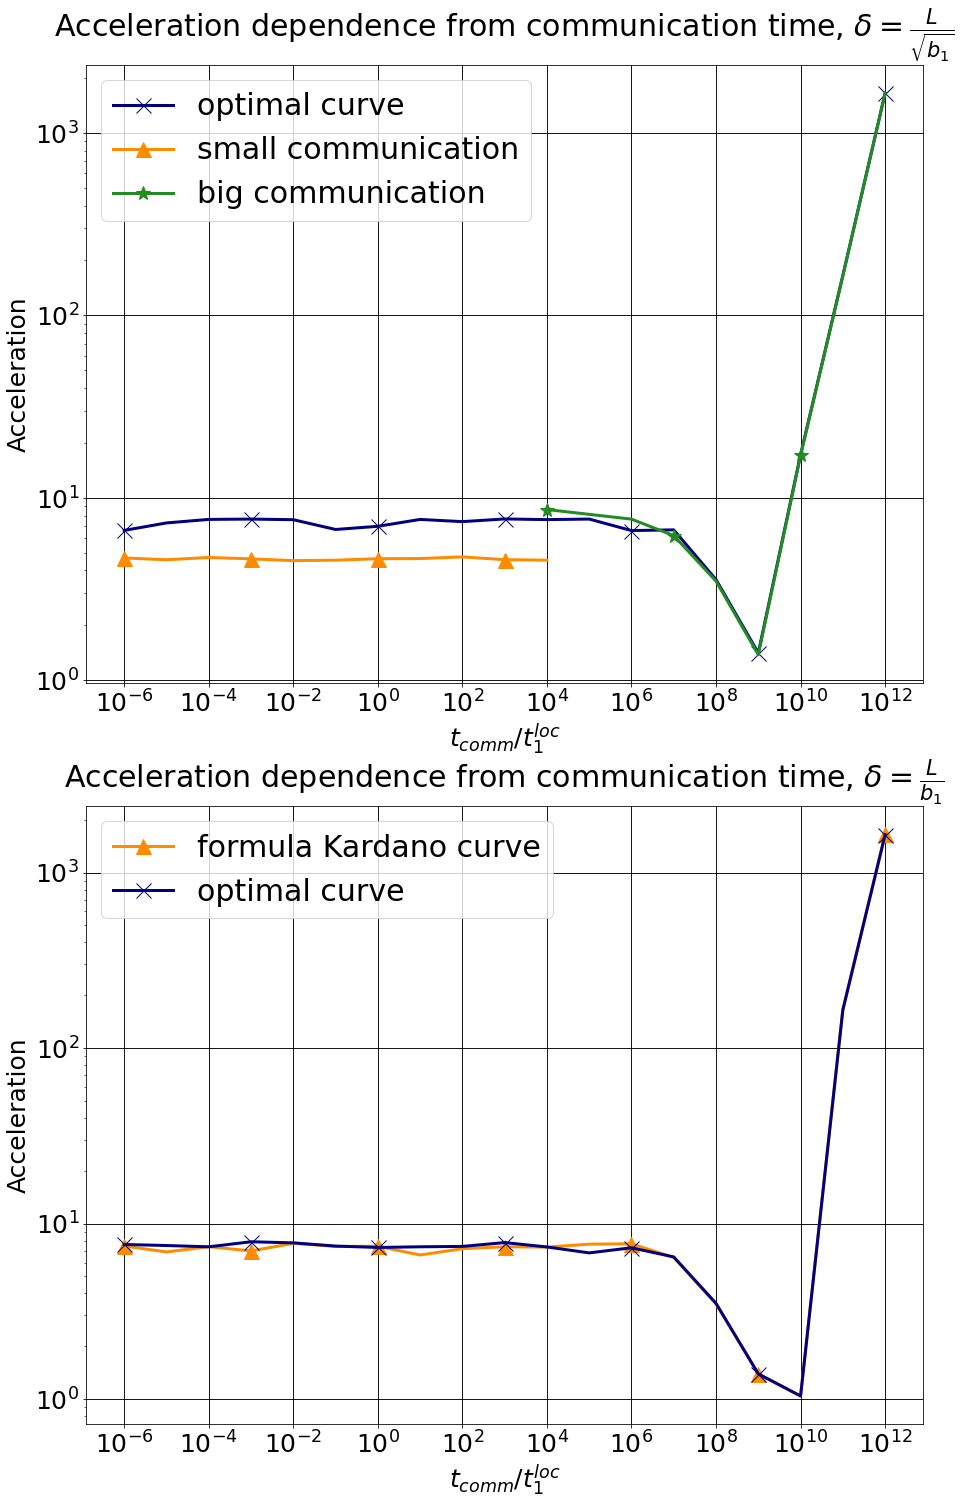

In [241]:
plt.figure(figsize=(15, 25))

pylab.subplot (2, 1, 1)
pylab.loglog(np.array([10**i for i in range(-6, 13)]), acceleration_opt, label = 'optimal curve', linewidth = 3, color = 'navy', marker = 'x', markersize = 15, markevery = (0, 3))
pylab.loglog(np.array([10**i for i in range(-6, 5)]), acceleration_small, label = 'small communication', linewidth = 3, color = 'darkorange', marker = '^', markersize = 15, markevery = (0, 3))
pylab.loglog(np.array([10**i for i in range(4, 13)]), acceleration_big, label = 'big communication', linewidth = 3, color = 'forestgreen', marker = '*', markersize = 15, markevery = (0, 3))
plt.legend(fontsize = 30)
plt.xlabel(r"$t_{comm}/t_1^{loc}$", fontsize = 25)
plt.ylabel(r"Acceleration", fontsize = 25)
plt.title(r"Acceleration dependence from communication time, $\delta = \frac{L}{\sqrt{b_1}}$", fontsize = 30)
plt.grid(color = 'k', linewidth = 0.9)
plt.xticks(np.array([10**i for i in range(-6, 13, 2)]), fontsize=25)
plt.yticks(fontsize=25)


pylab.subplot (2, 1, 2)
pylab.loglog(np.array([10**i for i in range(-6, 13)]), acceleration_problem2, label = 'formula Kardano curve', linewidth = 3, color = 'darkorange', marker = '^', markersize = 15, markevery = (0, 3))
pylab.loglog(np.array([10**i for i in range(-6, 13)]), acceleration_opt_problem2, label = 'optimal curve', linewidth = 3, color = 'navy', marker = 'x', markersize = 15, markevery = (0, 3))
plt.legend(fontsize = 30)
plt.xlabel(r"$t_{comm}/t_1^{loc}$", fontsize = 25)
plt.ylabel(r"Acceleration", fontsize = 25)
plt.title(r"Acceleration dependence from communication time, $\delta = \frac{L}{b_1}$", fontsize = 30)
plt.grid(color = 'k', linewidth = 0.9)
plt.xticks(np.array([10**i for i in range(-6, 13, 2)]), fontsize=25)
plt.yticks(fontsize=25)

### Для общего случая с $t_{comm} = 53$

In [93]:
def F(x, aa, bb, cc):
    return (2*aa * x**0.5 - 2*bb * x**(-0.5) + cc * x)

t_comm_w = 53*1e-1
b_1_0 = N/5
#0 < b_1 <= b_1_0
sum_t_loc2 = 1/(sum(1/t_loc2[i] for i in range(1, t_loc2.shape[0])))
a = - 0.5 * alpha * (N * sum_t_loc2 + t_comm_w)
b = - 0.5 * alpha * sum_t_loc2
c = beta * t_loc2[0]
root = (2*a**6 + 3*math.sqrt(3)*math.sqrt(4*a**3*b**3*c**6 + 27*b**4*c**8)+18*a**3*b*c**2+27*b**2*c**4)**(1/3)
xxx = a**2 / (3 * c**2) + (root)/(3*2**(1/3)*c**2) - (2**(0.33)*(-a**4-6*a*b*c**2)) / (3*c**2*root)
batch = list([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
if (b_1_0 < xxx):
    batch[0] = round(b_1_0)
else:
    batch[0] = round(xxx)
batch[1] = F(batch[0], a, b, c)
    
# b_1_0 < b_1 <= N 
a = 0.5 * alpha * t_loc2[0]
b = -0.5 * alpha * t_comm_w
c = beta * t_loc2[0]
if (N < xxx):
    batch[2] = round(N)
elif (xxx < b_1_0):
    batch[2] = round(b_1_0)
else:
    batch[2] = round(xxx)
batch[3] = F(batch[2], a, b, c)
if (batch[1] < batch[3]):
    batch[4] = batch[1]
    batch[5] = batch[0]
else:
    batch[4] = batch[3]
    batch[5] = batch[2]

b1w = batch[5]

In [94]:
def generate_bw(t_loc2):
    b1 = np.array([])
    S = (sum(1/t_loc2[i] for i in range(1, t_loc2.shape[0])))**(-1)
    b1 = np.append(b1, round(b1w))
    last = N 
    for i in range (1, t_loc2.shape[0]):
        last -= b1[-1]
        S = (sum(1/t_loc2[k] for k in range(i, t_loc2.shape[0])))**(-1)
        b1 = np.append(b1, round(last/t_loc2[i]*S))
    return b1
bw = generate_bw(t_loc2)
print(bw)

[ 119. 3627. 3627. 5440. 4352. 4352. 3627. 4352. 7254. 5440. 7254. 4352.
 5441. 3627. 7254. 4352. 4352. 3627. 4353. 3627. 7254.]


In [95]:
res5, time5 = accelarated_extragradient_division(0.75, 1/L, 0.01, 0.01, 0.01, X, y, np.ones(d), 10, bw, t_loc2, t_comm_w)

0
1
2
3
4
5
6
7
8
9


In [96]:
b = generate_b(t_loc)
res6, time6 = accelarated_extragradient_division(0.75, 1/L, 0.01, 0.01, 0.01, X, y, np.ones(d), 10, b, t_loc2, t_comm_w)

0
1
2
3
4
5
6
7
8
9


In [97]:
print("ускорили выполнение программы в {:.1f} раза".format(sum(time6)/sum(time5)))

ускорили выполнение программы в 1.8 раза


### Для общего случая с $t_{comm} = 10^{-9}$

In [28]:
def F(x, aa, bb, cc):
    return (2*aa * x**0.5 - 2* bb * x**(-0.5) + cc * x)

t_comm_w = 1e-9
b_1_0 = N/21
#0 < b_1 <= b_1_0
sum_t_loc2 = 1/(sum(1/t_loc2[i] for i in range(1, t_loc2.shape[0])))
b = - 0.5 * alpha * (N * sum_t_loc2 + t_comm_w)
a = - 0.5 * alpha * sum_t_loc2
c = beta * t_loc2[0]
root = (2*a**6 + 3*math.sqrt(3)*math.sqrt(4*a**3*b**3*c**6 + 27*b**4*c**8)+18*a**3*b*c**2+27*b**2*c**4)**(1/3)
xxx = a**2 / (3 * c**2) + (root)/(3*2**(1/3)*c**2) - (2**(0.33)*(-a**4-6*a*b*c**2)) / (3*c**2*root)
batch = list([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
if (b_1_0 < xxx):
    batch[0] = b_1_0
else:
    batch[0] = xxx
batch[1] = F(batch[0], a, b, c)
    
# b_1_0 < b_1 <= N 
a = 0.5 * alpha * t_loc2[0]
b = -0.5 * alpha * t_comm_w
c = beta * t_loc2[0]
if (N >=xxx):
    batch[2] = xxx
else:
    batch[2] = N
batch[3] = F(batch[2], a, b, c)
if (batch[1] < batch[3]):
    batch[4] = batch[1]
    batch[5] = batch[0]
else:
    batch[4] = batch[3]
    batch[5] = batch[2]

b1w = batch[5]

In [73]:
def generate_bw(t_loc2, b1_w):
    b1 = np.array([])
    S = (sum(1/t_loc2[i] for i in range(1, t_loc2.shape[0])))**(-1)
    b1 = np.append(b1, round(b1_w))
    last = N 
    for i in range (1, t_loc2.shape[0]):
        last -= b1[-1]
        S = (sum(1/t_loc2[k] for k in range(i, t_loc2.shape[0])))**(-1)
        b1 = np.append(b1, round(last/t_loc2[i]*S))
    return b1
bw = generate_bw(t_loc2, b1w)
print(bw)

[5.000e+00 5.087e+03 4.070e+03 4.070e+03 6.783e+03 4.070e+03 3.392e+03
 4.070e+03 6.783e+03 3.392e+03 3.392e+03 3.392e+03 5.087e+03 5.087e+03
 3.392e+03 5.087e+03 6.783e+03 5.087e+03 5.087e+03 6.784e+03 6.783e+03]


In [30]:
res7, time7 = accelarated_extragradient_division(0.75, 1/L, 0.01, 0.01, 0.01, X, y, np.ones(d), 50, bw, t_loc2, t_comm_w)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [31]:
b = generate_b(t_loc)
res8, time8 = accelarated_extragradient_division(0.75, 1/L, 0.01, 0.01, 0.01, X, y, np.ones(d), 50, b, t_loc2, t_comm_w)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [32]:
print("ускорили выполнение программы в {:.1f} раза".format(sum(time8)/sum(time7)))

ускорили выполнение программы в 7.3 раза


In [143]:
def F(x, aa, bb, cc):
    return (2*aa * x**0.5 - 2* bb * x**(-0.5) + cc * x)

In [232]:
acceleration_problem2 = []
for i in range (-15, 4):
    t_comm_w = 0.9*53*(10**i)
    b_1_0 = N/5
    #0 < b_1 <= b_1_0
    sum_t_loc2 = 1/(sum(1/t_loc2[i] for i in range(1, t_loc2.shape[0])))
    bb = - 0.5 * alpha * (N * sum_t_loc2 + 10**(i + 9))
    a = - 0.5 * alpha * sum_t_loc2
    c = beta * t_loc2[0]
    root = (2*a**6 + 3*math.sqrt(3)*math.sqrt(4*a**3*bb**3*c**6 + 27*bb**4*c**8)+18*a**3*bb*c**2+27*bb**2*c**4)**(1/3)
    xxx = a**2 / (3 * c**2) + (root)/(3*2**(1/3)*c**2) - (2**(0.33)*(-a**4-6*a*bb*c**2)) / (3*c**2*root)
    batch = list([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
    if (b_1_0 < xxx):
        batch[0] = round(b_1_0)
    else:
        batch[0] = round(xxx)
    batch[1] = F(batch[0], a, bb, c)

    # b_1_0 < b_1 <= N 
    a = 0.5 * alpha * t_loc2[0]
    bb = -0.5 * alpha * 10**(i + 9)
    c = beta * t_loc2[0]
    if (N < xxx):
        batch[2] = round(N)
    elif (xxx < b_1_0):
        batch[2] = round(b_1_0)
    else:
        batch[2] = round(xxx)
    
    batch[3] = F(batch[2], a, bb, c)
    if (batch[1] < batch[3]):
        batch[4] = batch[1]
        batch[5] = batch[0]
    else:
        batch[4] = batch[3]
        batch[5] = batch[2]

    b1w = batch[5]
    bw = generate_bw(t_loc, b1w)
    res1, time1 = accelarated_extragradient_division(0.75, 1/L, 0.01, 0.01, 0.01, X, y, np.ones(d), 5, b, t_loc, 0.9*53*(10**i))
    res2, time2 = accelarated_extragradient_division(0.75, 1/L, 0.01, 0.01, 0.01, X, y, np.ones(d), 5, bw, t_loc, 0.9*53*(10**i))
    acceleration_problem2.append(sum(time1)/sum(time2))
    print(i)

k =  1
k =  9
-15
k =  1
k =  13
-14
k =  1
k =  6
-13
k =  1
k =  10
-12
k =  1
k =  10
-11
k =  1
k =  11
-10
k =  1
k =  3
-9
k =  1
k =  20
-8
k =  1
k =  1
-7
k =  1
k =  14
-6
k =  1
k =  6
-5
k =  1
k =  9
-4
k =  1
k =  2
-3
k =  1
k =  18
-2
k =  1
k =  2
-1
k =  1
k =  1
0
k =  1
k =  19
1
k =  1
k =  0
2
k =  1
k =  0
3


# Вторая задача поиском питона

In [82]:
def minimum_finding1(t_comm):
    sum_t_loc = 1/(sum(1/t_loc[i] for i in range(1, t_loc.shape[0])))
    b_1_0 = N*(sum_t_loc)/(sum_t_loc + t_loc[0])
    #0 < b_1 <= b_1_0

    a1 = - alpha * sum_t_loc
    b1 = alpha * (sum_t_loc * N + t_comm)
    c1 = beta * t_loc[0]

    a2 = alpha * t_loc[0]
    b2 = alpha * (t_comm)
    c2 = beta * t_loc[0]
    
    def func1(x):
        return a1*x**(1/2) + b1*x**(-1/2) + c1*x
    def func2(x):
        return a2*x**(1/2) + b2*x**(-1/2) + c2*x

    res1 = minimize_scalar(func1, bounds=(1,floor(b_1_0)), method='bounded')
    res2 = minimize_scalar(func2, bounds=(ceil(b_1_0),N), method='bounded')

    #print(b_1_0)
    
    res11 = floor(res1.x)
    res12 = ceil(res1.x)
    res21 = floor(res2.x)
    res22 = ceil(res2.x)
    fres11 = func1(res11)
    fres12 = func1(res12)
    fres21 = func2(res21)
    fres22 = func2(res22)

    if (fres11 < fres12):
        result1 = [res11, fres11]
    else:
        result1 = [res12, fres12]


    if (fres21 < fres22):
        result2 = [res21, fres21]
    else:
        result2 = [res22, fres22]
    
    if (result1[1] < result2[1]):
        result = [result1[0], result1[1]]
    else:
        result = [result2[0], result2[1]]

    return result[0]

In [85]:
def generate_b_opt1(t_loc2, comm):
    b1 = np.array([])
    b1 = np.append(b1, minimum_finding1(comm))
    last = N 
    for i in range (1, t_loc.shape[0]):
        last -= b1[-1]
        S = (sum(1/t_loc[k] for k in range(i, t_loc.shape[0])))**(-1)
        b1 = np.append(b1, round(last/t_loc[i]*S))
    return b1

In [233]:
acceleration_opt_problem2 = []
for i in range (-15, 4):
    b_opt = generate_b_opt1(t_loc, 10**(i + 9))
    print(b_opt)
    res1, time1 = accelarated_extragradient_division(0.75, 1/L, 0.01, 0.01, 0.01, X, y, np.ones(d), 5, b, t_loc, 0.9*53*(10**i))
    res2, time2 = accelarated_extragradient_division(0.75, 1/L, 0.01, 0.01, 0.01, X, y, np.ones(d), 5, b_opt, t_loc, 0.9*53*(10**i))
    acceleration_opt_problem2.append(sum(time1)/sum(time2))
    print(i)

[   5. 4884. 4884. 4884. 4884. 4884. 4884. 4884. 4884. 4884. 4884. 4884.
 4884. 4884. 4884. 4884. 4884. 4884. 4883. 4884. 4883.]
k =  1
k =  10
-15
[   5. 4884. 4884. 4884. 4884. 4884. 4884. 4884. 4884. 4884. 4884. 4884.
 4884. 4884. 4884. 4884. 4884. 4884. 4883. 4884. 4883.]
k =  1
k =  15
-14
[   5. 4884. 4884. 4884. 4884. 4884. 4884. 4884. 4884. 4884. 4884. 4884.
 4884. 4884. 4884. 4884. 4884. 4884. 4883. 4884. 4883.]
k =  1
k =  2
-13
[   5. 4884. 4884. 4884. 4884. 4884. 4884. 4884. 4884. 4884. 4884. 4884.
 4884. 4884. 4884. 4884. 4884. 4884. 4883. 4884. 4883.]
k =  1
k =  14
-12
[   5. 4884. 4884. 4884. 4884. 4884. 4884. 4884. 4884. 4884. 4884. 4884.
 4884. 4884. 4884. 4884. 4884. 4884. 4883. 4884. 4883.]
k =  1
k =  7
-11
[   5. 4884. 4884. 4884. 4884. 4884. 4884. 4884. 4884. 4884. 4884. 4884.
 4884. 4884. 4884. 4884. 4884. 4884. 4883. 4884. 4883.]
k =  1
k =  11
-10
[   5. 4884. 4884. 4884. 4884. 4884. 4884. 4884. 4884. 4884. 4884. 4884.
 4884. 4884. 4884. 4884. 4884. 4884. 4883

In [171]:
acceleration_opt

[8.047747012731415,
 7.874974802044819,
 7.629603521622855,
 7.414966086057506,
 7.936509757459705,
 8.194402243278509,
 7.6734280978264335,
 7.744701115637917,
 7.820228634884067,
 7.698401355612027,
 8.411133680502946,
 7.668407869630238,
 7.533050429702187,
 4.0275648055463416,
 1.4363387661849498,
 1.0469462299979901,
 163.59566131421164,
 1645.7302311038534,
 17323.42862569429]

In [219]:
res1, time1 = accelarated_extragradient_division(0.75, 1/L, 0.01, 0.01, 0.01, X, y, np.ones(d), 5, b, t_loc, 53*(10**0))

k =  1


In [220]:
print(b)

[ 1494. 18400.  1539.  2762.  2520.  8668.  2644.  1415.  6090.  6519.
 12309.  2439.  3910.  2982.  8419.  1323.  1643.  1677.  1074.  3284.]


In [221]:
b_opt = generate_b_opt(t_loc, 10**(9))
print(b_opt)
res2, time2 = accelarated_extragradient_division(0.75, 1/L, 0.01, 0.01, 0.01, X, y, np.ones(d), 5, b_opt, t_loc, 53*(10**0))
print(sum(time1)/sum(time2))

[20813.  3843.  3844.  3843.  3844.  3843.  3844.  3843.  3844.  3844.
  3843.  3844.  3843.  3844.  3843.  3844.  3843.  3844.  3843.  3844.
  3843.]
k =  8
1.3480617908793815


In [179]:
N

97683

#### Вывод: 

|           | $\delta = \frac{L}{\sqrt{b_1}}$                     | | $\delta = \frac{L}{b_1}$                    | |
|-----------|:-------------------------------:|--------------------|:------------------------:|--------------------|
|           |       Большие коммуникации      | Малые коммуникации |   Большие коммуникации   | Малые коммуникации |
| Ускорение |               1.4               |         5.6        |            1.2           |         9.1        |